In [1]:
!pip install scrapetube
!pip install opencv-python
!pip install sklearn
!pip install h2o4gpu
!mkdir d1_img

mkdir: cannot create directory ‘d1_img’: File exists


In [2]:
import scrapetube
import pandas as pd
import requests
import json
from csv import writer
import time
import numpy as np
from urllib.request import urlopen
from collections import Counter
import cv2
import argparse
import cv2

In [3]:
channelid=["channel_id"]
api="your_youtube_api_key"

In [4]:
allvidid=pd.DataFrame(columns=['vidid'])
for i in channelid:
    videos = scrapetube.get_channel(i)
    for video in videos:
        print(video['videoId'])
        df=pd.DataFrame([[video['videoId']]],columns=['vidid'])
        allvidid=pd.concat([allvidid,df])
allvidid.to_csv("vidid.csv",header=True,index=False)


VfcRqm0Rz1k
U-et5eaFH18
1fGcCsEcMMw
G7uMBK_27mM
ecK0Ht6Yaoc
5830uX5NBQI
jRNRmMsozIo
z1CLouFrbSc
71n_YeHWRCw
yGlV9-c0nVg


In [5]:
vid = pd.read_csv("vidid.csv")
pd.DataFrame({},columns=['vidtitle','chanid','viddesc','vidpub','channame','vidtags','vidcat','vidlang','viddu','vidview','vidlikes','vidcom','vidthumb','vidid']).to_csv("exdata.csv",header=True, index=False)
def yttimeconvert(duration):
   day_time = duration.split('T')
   day_duration = day_time[0].replace('P', '')
   day_list = day_duration.split('D')
   if len(day_list) == 2:
      day = int(day_list[0]) * 60 * 60 * 24
      day_list = day_list[1]
   else:
      day = 0
      day_list = day_list[0]
   hour_list = day_time[1].split('H')
   if len(hour_list) == 2:
      hour = int(hour_list[0]) * 60 * 60
      hour_list = hour_list[1]
   else:
      hour = 0
      hour_list = hour_list[0]
   minute_list = hour_list.split('M')
   if len(minute_list) == 2:
      minute = int(minute_list[0]) * 60
      minute_list = minute_list[1]
   else:
      minute = 0
      minute_list = minute_list[0]
   second_list = minute_list.split('S')
   if len(second_list) == 2:
      second = int(second_list[0])
   else:
      second = 0
   return day + hour + minute + second
def main(urs):
   url = "https://youtube.googleapis.com/youtube/v3/videos?part=snippet%2CcontentDetails%2Cstatistics&id="+urs+"&key="+api
   response = urlopen(url)
   json_load = json.loads(response.read())

   try:
      vidtitle=json_load['items'][0]['snippet']['title']
   except:
      vidtitle=""
   try:
      chanid=json_load['items'][0]['snippet']['channelId']
   except:
      chanid=np.nan
   try:
      viddesc=json_load['items'][0]['snippet']['description']
   except:
      viddesc=np.nan
   try:
      vidpub=json_load['items'][0]['snippet']['publishedAt']
   except:
      vidpub=np.nan
   try:
      channame=json_load['items'][0]['snippet']['channelTitle']
   except:
      channame=np.nan
   try:
      vidtags=json_load['items'][0]['snippet']['tags']
   except:
      vidtags=np.nan
   try:
      vidcat=json_load['items'][0]['snippet']['categoryId']
   except:
      vidcat=np.nan
   try:
      vidlang=json_load['items'][0]['snippet']['defaultAudioLanguage']
   except:
      vidlang=np.nan
   try:
      viddu=time.strftime("%H:%M:%S",time.gmtime(yttimeconvert(json_load['items'][0]['contentDetails']['duration'])))
   except:
      viddu=np.nan
   try:
      vidview=json_load['items'][0]['statistics']['viewCount']
   except:
      vidview=np.nan
   try:
      vidlikes=json_load['items'][0]['statistics']['likeCount']
   except:
      vidlikes=np.nan
   try:
      vidcom=json_load['items'][0]['statistics']['commentCount']
   except:
      vidcom=np.nan
   try:
      vidthumb=json_load['items'][0]['snippet']['thumbnails']['maxres']['url']
   except:
      vidthumb=json_load['items'][0]['snippet']['thumbnails']['high']['url']
   try:
      vidid=json_load['items'][0]['id']
   except:
      vidid=urs
   df2 = pd.DataFrame([[vidtitle,chanid,viddesc,vidpub,channame,vidtags,vidcat,vidlang,viddu,vidview,vidlikes,vidcom,vidthumb,vidid]],columns=['vidtitle','chanid','viddesc','vidpub','channame','vidtags','vidcat','vidlang','viddu','vidview','vidlikes','vidcom','vidthumb','vidid'])
   return df2
    

for i in range(0,len(vid.index+1)):
   data = main(str(vid.iloc[i,0]))
   print (i)
   data.to_csv("exdata.csv", mode='a', header=False, index=False)
   


0
1
2
3
4
5
6
7
8
9


In [6]:
cldata = pd.read_csv("exdata.csv")
cldata = cldata.drop_duplicates(subset=['vidid'])

In [7]:
for i in range(len(cldata)):
    img_data = requests.get(cldata.iloc[i,12]).content
    with open("./d1_img/"+cldata.iloc[i,13]+".jpg", 'wb') as handler:
        handler.write(img_data)

In [8]:
from sklearn.cluster import KMeans
#from h2o4gpu.solvers import KMeans
colordf=pd.DataFrame({},columns=['vidid','color'])
def get_dominant_color(image, k=4, image_processing_size=None):

    # resize image if new dims provided
    if image_processing_size is not None:
        image = cv2.resize(image, image_processing_size, interpolation=cv2.INTER_AREA)

    # reshape the image to be a list of pixels
    image = image.reshape((image.shape[0] * image.shape[1], 3))

    # cluster the pixels and assign labels
    clt = KMeans(n_clusters=k)
    labels = clt.fit_predict(image)

    # count labels to find most popular
    label_counts = Counter(labels)

    # subset out most popular centroid
    dominant_color = clt.cluster_centers_[label_counts.most_common(1)[0][0]]

    return list(dominant_color)


# construct the argument parser and parse the arguments

# read in image of interest
for i in range(len(cldata)):
  bgr_image = cv2.imread("./d1_img/"+cldata.iloc[i,13]+".jpg")
# convert to HSV; this is a better representation of how we see color
  hsv_image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2HSV)

  # extract dominant color
  # (aka the centroid of the most popular k means cluster)
  dom_color = get_dominant_color(hsv_image, k=6)

  # create a square showing dominant color of equal size to input image
  dom_color_hsv = np.full(bgr_image.shape, dom_color, dtype='uint8')
  # convert to bgr color space for display
  dom_color_bgr = cv2.cvtColor(dom_color_hsv, cv2.COLOR_HSV2BGR)

  # concat input image and dom color square side by side for display
  output_image = np.hstack((bgr_image, dom_color_bgr))

  # show results to screen
  #cv2_imshow( output_image)
  #print(dom_color_hsv[1][1])
  #df2=pd.DataFrame(( pd.Series([cldata.iloc[i,13],dom_color_hsv[1][1]])))
  colordf = colordf.append( pd.Series([cldata.iloc[i,13],dom_color_hsv[1][1]],index=colordf.columns),ignore_index=True)
  colordf.to_csv("color.csv", mode='a', header=False, index=False)


Streaming output truncated to the last 5000 lines.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1

In [9]:
newdf = pd.merge(cldata,colordf)

In [76]:
colordf.iloc[0,1][1]

166

In [10]:
excolor = pd.DataFrame({},columns=['vidid','color','hue','sat','val'])
for i in range(len(colordf)):
  excolor = excolor.append({'vidid':colordf.iloc[i,0],'color':colordf.iloc[i,1],'hue':np.array(colordf.iloc[i,1][0]),'sat':np.array(colordf.iloc[i,1][1]),'val':np.array(colordf.iloc[i,1][2])},ignore_index=True)

In [71]:
excolor['hue'].between(0,60).shape[0]

10

In [11]:
excolor

,vidid,color,hue,sat,val
0,VfcRqm0Rz1k,"[119, 166, 122]",119,166,122
1,U-et5eaFH18,"[144, 139, 100]",144,139,100
2,1fGcCsEcMMw,"[121, 135, 60]",121,135,60
3,G7uMBK_27mM,"[0, 0, 1]",0,0,1
4,ecK0Ht6Yaoc,"[0, 0, 1]",0,0,1
5,5830uX5NBQI,"[0, 0, 1]",0,0,1
6,jRNRmMsozIo,"[108, 38, 93]",108,38,93
7,z1CLouFrbSc,"[125, 247, 21]",125,247,21
8,71n_YeHWRCw,"[1, 6, 19]",1,6,19
9,yGlV9-c0nVg,"[125, 219, 11]",125,219,11


In [17]:
excolor[excolor['hue'].between(0,60)].shape[0]

4

In [18]:
colorplot=pd.DataFrame({},columns=['color','value'])
colorplot=colorplot.append({'color':'red','value':excolor[excolor['hue'].between(0,60)].shape[0]},ignore_index=True)
colorplot=colorplot.append({'color':'yellow','value':excolor[excolor['hue'].between(61,120)].shape[0]},ignore_index=True)
colorplot=colorplot.append({'color':'green','value':excolor[excolor['hue'].between(121,180)].shape[0]},ignore_index=True)
colorplot=colorplot.append({'color':'cyan','value':excolor[excolor['hue'].between(181,240)].shape[0]},ignore_index=True)
colorplot=colorplot.append({'color':'blue','value':excolor[excolor['hue'].between(241,300)].shape[0]},ignore_index=True)
colorplot=colorplot.append({'color':'magenta','value':excolor[excolor['hue'].between(301,360)].shape[0]},ignore_index=True)

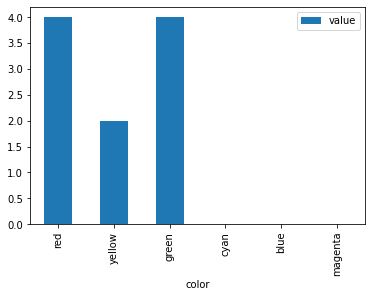

In [21]:
colorplot.plot.bar(x="color")